In [1]:
# Sandbox calcs
# import numpy as np
# k = np.array([[37.1,-6.55],
#               [-6.55,43.99]])
# eigenvalues, eigenvectors = np.linalg.eig(k)
# print eigenvectors, eigenvalues

# Dimensionality Reduction with a Simple Dataset
Here we are going to start with the iris dataset. This is a very simple dataset that is four dimensions. Details about this data are rampant on the web. 
- Here is a good explanation from UCI: https://archive.ics.uci.edu/ml/datasets/Iris 
- And even more details from Wikipedia: http://en.wikipedia.org/wiki/Iris_flower_data_set 

Let's get started. We will use scikit for this analysis, which has a built-in loading mechanism for the iris dataset.

In [1]:
from sklearn import datasets as ds

iris = ds.load_iris() # wow that was simple to load up!

print (iris['DESCR']) # a description of the dataset

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [2]:
# let's convert it to a pandas data frame and visualize it
import pandas as pd
import numpy as np

df = pd.DataFrame(iris.data,columns=iris.feature_names)
# add in the class targets and names
df['target'] = iris.target.astype(np.int)
print (df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
target               150 non-null int32
dtypes: float64(4), int32(1)
memory usage: 5.4 KB
None


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


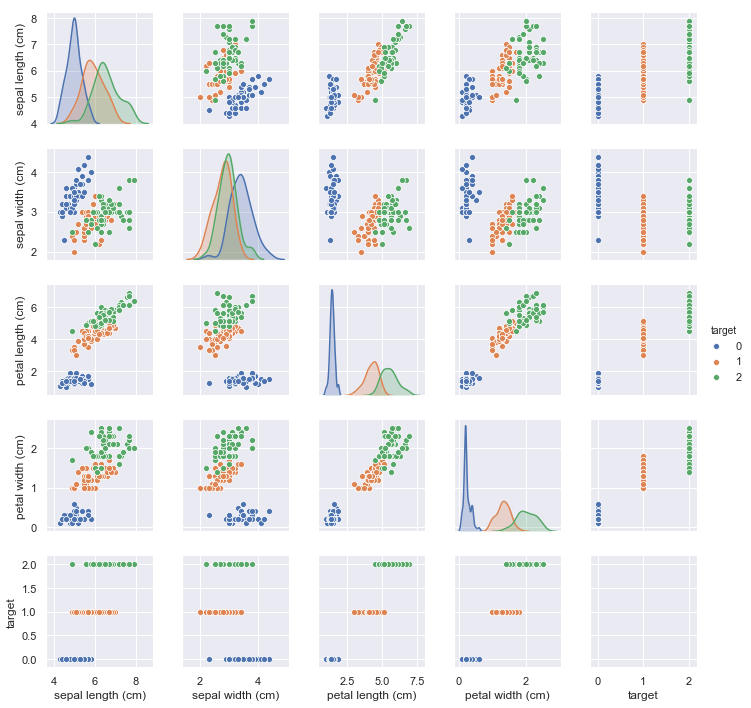

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

sns.pairplot(df, hue="target", height=2)

In [5]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it (Note this has y also)

# print the components

# _ in names in scikit learn are for properties that are not set until you have fit the object to data
print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

pca: [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
lda: [[-0.82937764 -1.53447307  2.20121166  2.81046031]
 [ 0.02410215  2.16452123 -0.93192121  2.83918785]]


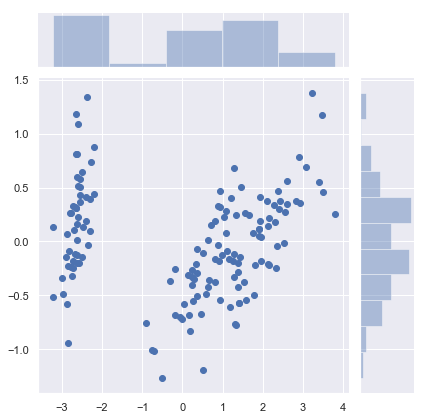

<Figure size 432x288 with 0 Axes>

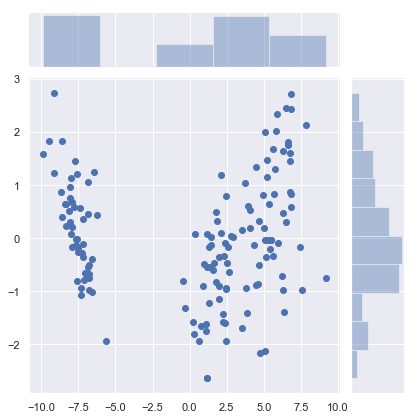

In [59]:
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, iris.feature_names) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, iris.feature_names) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])


#from pandas.tools.plotting import scatter_plot

## Note with the latest changes the axis labelling is off.
## Will need to fix this for better visualization

# scatter plot the output, with the names crated from the weights
# ax = scatter_plot(df_pca, pca_weight_strings[0], pca_weight_strings[1], c=y, s=(y+2)*10)
ax = sns.jointplot(x=pca_weight_strings[0], y=pca_weight_strings[1], data=df_pca, kind='scatter')
newfig = plt.figure()
#ax = scatter_plot(df_lda, lda_weight_strings[0], lda_weight_strings[1], c=y, s=(y+2)*10)
ax = sns.jointplot(x=lda_weight_strings[0], y=lda_weight_strings[1], data=df_lda, kind='scatter')
#ax = plt.scatter(x = df_pca[pca_weight_strings[0]], y = df_pca[pca_weight_strings[1]], c=y, alpha=0.5)
plt.show()

# A More Complicated Dataset, Faces
This is code manipulated from Olivier Grisel's eigen face classification demonstration. You can find the original notebook here: http://nbviewer.ipython.org/github/ogrisel/notebooks/blob/master/Labeled%20Faces%20in%20the%20Wild%20recognition.ipynb

In [61]:
# fetch the images for the dataset
# this will take a long time the first run because it needs to download
# after the first time, the dataset will be save to your disk (in sklearn package somewhere) 
# if this does not run, you may need additional libraries installed on your system (install at your own risk!!)
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [62]:
# get some of the specifics of the dataset
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (50*37 )# the size of the images are the size of the feature vectors

n_samples: 1288
n_features: 1850
n_classes: 7
Original Image Sizes 50by37
1850


So basically each feature vector is a giant image with the rows of the image just stacked one after the other into a giant vector. The image sizes are 50 pixels by 37 pixels. This gives us 50x37=1850 pixels per image.

So we are using the pixel values in the images as the values of the features. Wow. That's a lot of features.

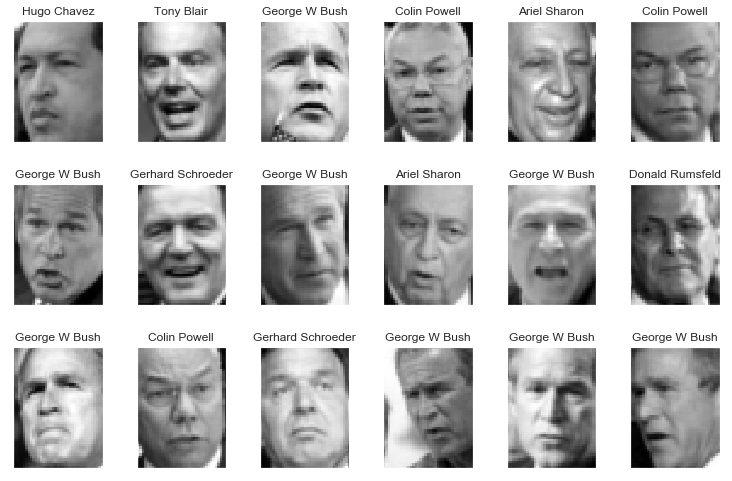

In [63]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, names[y], h, w) # defaults to showing a 3 by 6 subset of the faces

## Reconstruct Using Full PCA

In [73]:
# lets do some PCA of the features and go from 1850 features to 300 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 1288 faces
Wall time: 310 ms


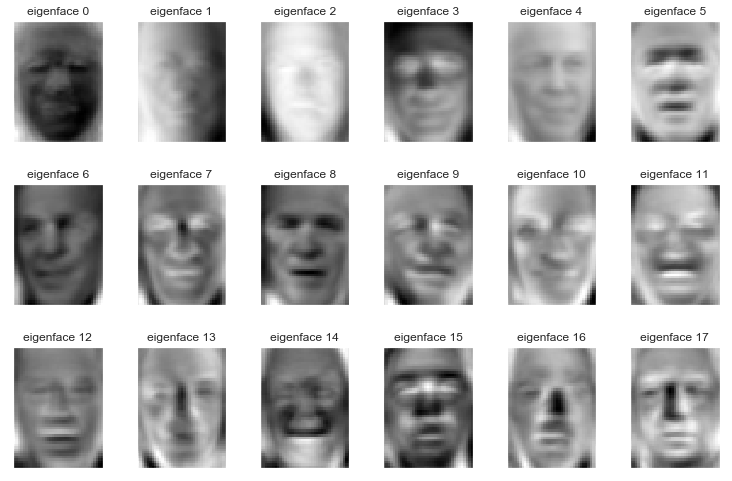

In [74]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [108]:
def reconstruct_image(trans_obj,org_features,faces):
    low_rep = trans_obj.transform(org_features)[0]
    rec_image = np.zeros(faces[0].shape)

    for idx,weight in enumerate(low_rep):
        rec_image += weight*faces[idx]
    return low_rep, rec_image
    
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct,:].reshape(1,n_features)
                                                                        ,eigenfaces)

Text(0.5, 1.0, 'Reconstructed from Full PCA')

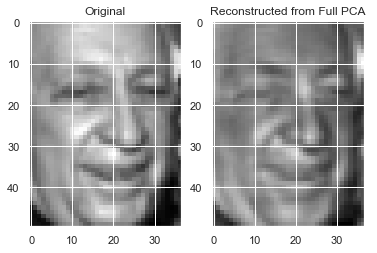

In [109]:
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

## Now Let's Use Randomized PCA

In [111]:
# lets do some PCA of the features and go from 1850 features to 300 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components,svd_solver='randomized')
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 1288 faces
Wall time: 284 ms


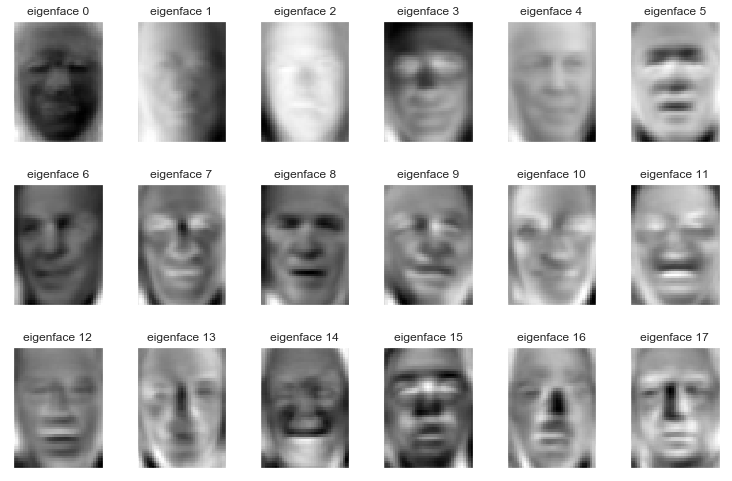

In [112]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [114]:
# okay, so lets choose an image and reconstruct it using the eigenfaces
from random import random as rd
from ipywidgets import widgets  # make this interactive!

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct].reshape(1,n_features)
                                                                            ,eigenfaces)

    plt.subplot(1,2,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.subplot(1,2,2)
    plt.imshow(reconstructed_image, cmap=plt.cm.gray)
    plt.title('Reconstructed')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(1,100,1),__manual=True)

interactive(children=(IntSlider(value=50, description='idx_to_reconstruct', min=1), Output()), _dom_classes=('…

<function __main__.plt_reconstruct(idx_to_reconstruct)>